In [1]:
import sys
print(sys.version)
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

import pandas as pd
import numpy as np
import math

import random
import matplotlib.pyplot as plt
%matplotlib inline

3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
2.7.0
2.7.0


# Синусоида

create period-10 sin wave with 500 cycles
In total, the sin wave time series length is 5001


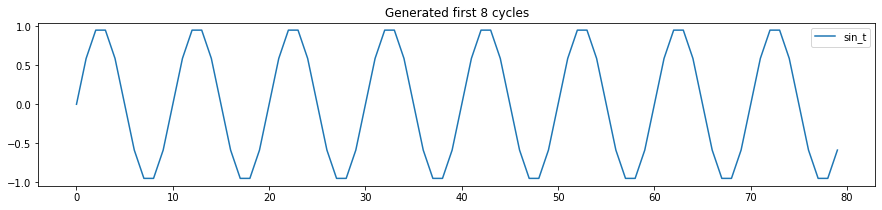

In [2]:
def noisy_sin(steps_per_cycle = 50,
              number_of_cycles = 500,
              random_factor = 0.4):
    '''
    random_factor    : amont of noise in sign wave. 0 = no noise
    number_of_cycles : The number of steps required for one cycle
    
    Return : 
    pd.DataFrame() with column sin_t containing the generated sin wave 
    '''
    random.seed(0)
    df = pd.DataFrame(np.arange(steps_per_cycle * number_of_cycles + 1), columns=["t"])
    df["sin_t"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)+ random.uniform(-1.0, +1.0) * random_factor))
    df["sin_t_clean"] = df.t.apply(lambda x: math.sin(x * (2 * math.pi / steps_per_cycle)))
    print("create period-{} sin wave with {} cycles".format(steps_per_cycle,number_of_cycles))
    print("In total, the sin wave time series length is {}".format(steps_per_cycle*number_of_cycles+1))
    return(df)



steps_per_cycle = 10
df = noisy_sin(steps_per_cycle=steps_per_cycle,
              random_factor = 0)

n_plot = 8
df[["sin_t"]].head(steps_per_cycle * n_plot).plot(
      title="Generated first {} cycles".format(n_plot),
      figsize=(15,3))

# Тренировочное и тестовое множество

In [3]:
def _load_data(data, n_prev = 100):  
    """
    data should be pd.DataFrame()
    """

    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].to_numpy())
        docY.append(data.iloc[i+n_prev].to_numpy())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

length_of_sequences = 2
test_size = 0.25
ntr = int(len(df) * (1 - test_size))
df_train = df[["sin_t"]].iloc[:ntr]
df_test  = df[["sin_t"]].iloc[ntr:]
(X_train, y_train) = _load_data(df_train, n_prev = length_of_sequences)
(X_test, y_test)   = _load_data(df_test, n_prev = length_of_sequences)  
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3748, 2, 1) (3748, 1) (1249, 2, 1) (1249, 1)


# Модель

На вход подаются двумерные векторы $x_t$

$$h_t=tanh(x^T_t w_{1x}+h^T_{t − 1} w_{1h}+b_1) \\
x_{t+1}=h^T_t w_2+b_2$$

[cite]

As a deep learning model, I consider the simplest possible RNN model: RNN with a single hidden unit followed by fully connected layer with a single unit.

    The RNN layer contains 3 weights: 1 weight for input, 1 weight for hidden unit, 1 weight for bias
    The fully connected layer contains 2 weights: 1 weight for input (i.e., the output from the previous RNN layer), 1 weight for bias

In total, there are only 5 weights in this model.

[/cite]

In [4]:
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dense, Activation 
from keras.layers.recurrent import SimpleRNN

In [5]:
def define_model(length_of_sequences, batch_size = None, stateful = False, activation=None):
    in_out_neurons = 1
    hidden_neurons = 1
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  
    
    if activation is None:
        print('tanh')
        rnn = SimpleRNN(hidden_neurons, 
                        return_sequences=False,
                        stateful = stateful,
                        name="RNN")(inp)
    else:
        print(activation)
        rnn = SimpleRNN(hidden_neurons, 
                        return_sequences=False,
                        stateful = stateful,
                        name="RNN", activation=activation)(inp)

    dens = Dense(in_out_neurons,name="dense")(rnn)
    model = Model(inputs=[inp],outputs=[dens])
    
    model.compile(loss="mean_squared_error", optimizer="rmsprop")

    
    return(model,(inp,rnn,dens))
## use the default values for batch_size, stateful
model, (inp,rnn,dens) = define_model(length_of_sequences = X_train.shape[1])
model.summary()

tanh
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 1)]            0         
                                                                 
 RNN (SimpleRNN)             (None, 1)                 3         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


```
tf.keras.layers.SimpleRNN(
    units,
    activation="tanh",
    use_bias=True,
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False,
    **kwargs
)
```

Arguments
- units: Positive integer, dimensionality of the output space.

- activation: Activation function to use. Default: hyperbolic tangent (tanh). If you pass None, no activation is applied (ie. "linear" activation: a(x) = x).
- use_bias: Boolean, (default True), whether the layer uses a bias vector.
- kernel_initializer: Initializer for the kernel weights matrix, used for the linear transformation of the inputs. Default: glorot_uniform.
- recurrent_initializer: Initializer for the recurrent_kernel weights matrix, used for the linear transformation of the recurrent state. Default: orthogonal.
- bias_initializer: Initializer for the bias vector. Default: zeros.
- kernel_regularizer: Regularizer function applied to the kernel weights matrix. Default: None.
- recurrent_regularizer: Regularizer function applied to the recurrent_kernel weights matrix. Default: None.
- bias_regularizer: Regularizer function applied to the bias vector. Default: None.
- activity_regularizer: Regularizer function applied to the output of the layer (its "activation"). Default: None.
- kernel_constraint: Constraint function applied to the kernel weights matrix. Default: None.
- recurrent_constraint: Constraint function applied to the recurrent_kernel weights matrix. Default: None.
- bias_constraint: Constraint function applied to the bias vector. Default: None.
- dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs. Default: 0.
- recurrent_dropout: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state. Default: 0.
- return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.
- return_state: Boolean. Whether to return the last state in addition to the output. Default: False
- go_backwards: Boolean (default False). If True, process the input sequence backwards and return the reversed sequence.
- __stateful: Boolean (default False). If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.__
- unroll: Boolean (default False). If True, the network will be unrolled, else a symbolic loop will be used. Unrolling can speed-up a RNN, although it tends to be more memory-intensive. Unrolling is only suitable for short sequences.


In [6]:
hist = model.fit(X_train, y_train, batch_size=600, epochs=500, 
                 verbose=0,validation_split=0.05)

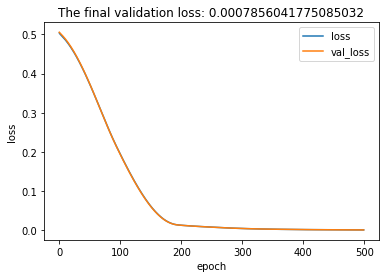

In [7]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Predicted vs real

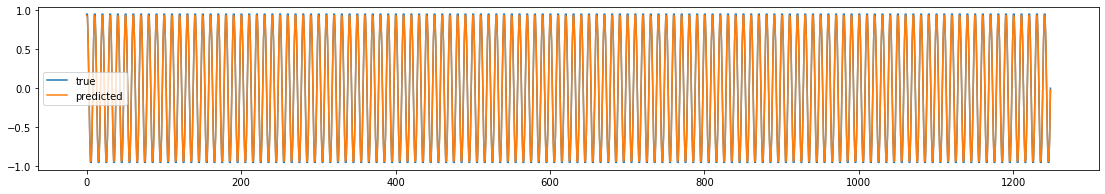

In [8]:
y_pred = model.predict(X_test)
plt.figure(figsize=(19,3))

plt.plot(y_test,label="true")
plt.plot(y_pred,label="predicted")
plt.legend()
plt.show()

# Посмотрим на веса

In [9]:
ws = {}
for layer in model.layers:
    ws[layer.name] = layer.get_weights()
ws

{'input_1': [],
 'RNN': [array([[0.6293729]], dtype=float32),
  array([[-0.67726356]], dtype=float32),
  array([-0.00109619], dtype=float32)],
 'dense': [array([[2.6512213]], dtype=float32),
  array([-0.00097437], dtype=float32)]}

# Что в скрытом слое?

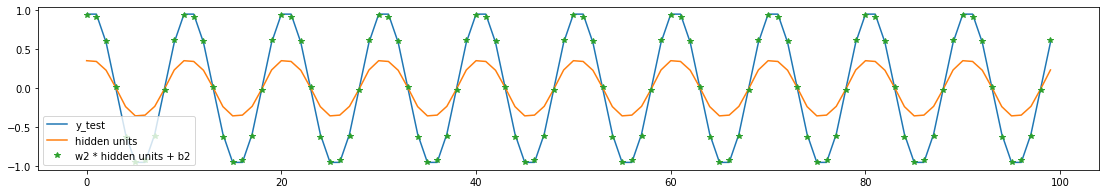

In [10]:
rnn_model = Model(inputs=[inp],outputs=[rnn])
rnn_model.compile(loss="mean_squared_error", optimizer="rmsprop")
hidden_units = rnn_model.predict(X_test).flatten()

upto = 100
predicted_sin_wave = ws["dense"][0][0][0]*hidden_units + ws["dense"][1][0]

plt.figure(figsize=(19,3))
plt.plot(y_test[:upto],label="y_test")
plt.plot(hidden_units[:upto],label="hidden units")
plt.plot(predicted_sin_wave[:upto],"*",
         label="w2 * hidden units + b2")
plt.legend()
plt.show()

# Предсказание по одной точке (руками)

In [11]:
def RNNmodel(ws,x,h=0):
    '''
    ws: predicted weights 
    x : scalar current sign value
    h : scalar RNN hidden unit 
    '''
           
    h = np.tanh(x*ws["RNN"][0][0][0] + h*ws["RNN"][1][0][0] + ws["RNN"][2][0])
    x = h*ws["dense"][0][0][0] + ws["dense"][1][0]
    
    return(x,h)

$$\widehat{x}_{t+1},h_{t+1}=RNNmodel(x_t,h_t)$$

In [12]:
upto = 50 ## predict the first  sin values
xhat, hs_hand = [], []
for i, x in enumerate(df_test.values):
    if i == 0:
        h = 0 ## initial hidden layer value is zero
        xstar = x
        print("initial value of sin x_0 = {}, h_0 = {}".format(x,h))
    hs_hand.append(h)
    xhat.append(xstar[0])
    xstar, h = RNNmodel(ws,x, h)

assert len(df_test.values) == len(xhat)

initial value of sin x_0 = [-1.27375647e-13], h_0 = 0


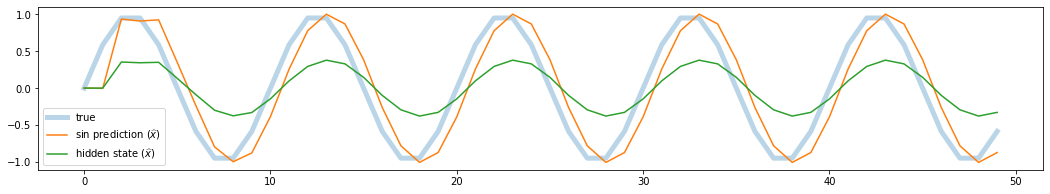

In [13]:


plt.figure(figsize=(18,3))
plt.plot(df_test.values[:upto],label="true",alpha=0.3,linewidth=5)
plt.plot(xhat[:upto],label="sin prediction ($\widehat{x}$)")
plt.plot(hs_hand[:upto],label="hidden state ($\widehat{x}$)")
plt.legend()



Предсказание запаздывает. Посчитаем функцию потерь

In [14]:
"validation loss {:3.2f}".format(np.mean((np.array(xhat) - df_test["sin_t"].values)**2))

'validation loss 0.07'

# Предсказание функцией Keras

Обратим внимание, что точки в обучающей и тестовой выорке идут парами

In [15]:
y_test_from_keras = model.predict(X_test).flatten()

Они совпадают с предсказанием "вручную"

In [16]:
np.all(predicted_sin_wave == y_test_from_keras)

True

Предсказание начинается с 3 элемента. Добавим NaN вместо первых двух

In [17]:
y_test_from_keras = [np.NaN, np.NaN] + list(y_test_from_keras.flatten())
h_test_from_keras = [np.NaN, np.NaN] + list(hidden_units.flatten())

validation loss 0.00079


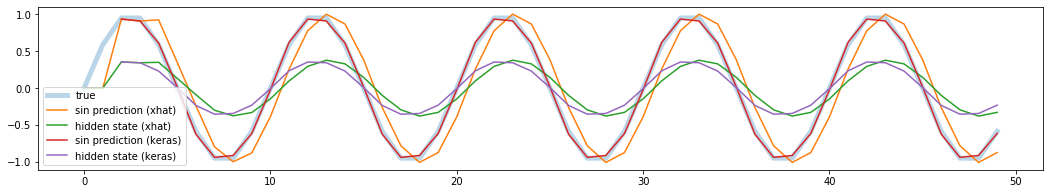

In [18]:
plt.figure(figsize=(18,3))
plt.plot(df_test.values[:upto],label="true",alpha=0.3,linewidth=5)
plt.plot(xhat[:upto],label="sin prediction (xhat)")
plt.plot(hs_hand[:upto],label="hidden state (xhat)")
plt.plot(y_test_from_keras[:upto],label="sin prediction (keras)")
plt.plot(h_test_from_keras[:upto],label="hidden state (keras)")
plt.legend()

print("validation loss {:6.5f}".format(np.nanmean((np.array(y_test_from_keras) - df_test["sin_t"].values)**2)))

As the BPTT algorithm only passed back 2 steps, the model assumes that:

- the hidden units are initialized to zero every 2 steps.
- the prediction of the next sin value ($x_{t+1}$) is based on the hidden unit ($h_t$) which is created by updating the hidden units twice in the past assuming that $h_{t−1}=0$.

$$\widehat{x}_t,h_t=RNNmodel(x_{t−1},0) \\
x_{t+1},−=RNNmodel(x_t,h_t)$$

__Note that the intermediate predicted sin $\widehat{x}_t$ based on $h_{t−1}=0$ should not be used as the predicted sin value. This is because the $x_t$ was not directly used to evaluate the loss function.__

# Предсказание функции Keras руками

In [19]:
def myRNNpredict(ws,X):
    X = X.flatten() # to 1-d shape
    h = 0
    for i in range(len(X)):
        x,h = RNNmodel(ws,X[i],h)
    return(x,h)


xs, hs = [], []
for i in range(X_test.shape[0]):
    x, h = myRNNpredict(ws,X_test[i,:,:])
    xs.append(x)
    hs.append(h)

In [20]:
print("All sin estimates agree with ones from Keras = {}".format(
    np.all(np.abs( np.array(xs) - np.array(y_test_from_keras[2:]) ) < 1E-5)))

print("All hidden state estmiates agree with ones frome Keras = {}".format(
    np.all(np.abs( np.array(hs) - np.array(h_test_from_keras[2:]) ) < 1E-5)) )

All sin estimates agree with ones from Keras = True
All hidden state estmiates agree with ones frome Keras = True


Есть способ получить предсказание "вручную" через Keras. Нужно установить флаг ___stateful___. В этом случае момент обнуления скрытого слоя можно установит вручную.

In [21]:
model_stateful,_ = define_model(length_of_sequences = 1, 
                              batch_size=1, 
                              stateful = True)
model_stateful.summary()

tanh
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(1, 1, 1)]               0         
                                                                 
 RNN (SimpleRNN)             (1, 1)                    3         
                                                                 
 dense (Dense)               (1, 1)                    2         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


Установим полученные ранее веса

In [22]:
for layer in model.layers:        
    for layer_predict in model_stateful.layers:
        if (layer_predict.name == layer.name):
            layer_predict.set_weights(layer.get_weights())
            break

Устанавливаем $h_0 = 0$

In [23]:


pred = df_test.values[0][0]
stateful_sin = []
model_stateful.reset_states()
for i in range(df_test.shape[0]):
    stateful_sin.append(pred)
    pred = model_stateful.predict(df_test.values[i].reshape(1,1,1))[0][0]
    
stateful_sin = np.array(stateful_sin)



In [24]:
print("All predicted sin values with stateful model agree to xhat = {}".format(
    np.all(np.abs(np.array(stateful_sin) - np.array(xhat))< 1E-5)))

All predicted sin values with stateful model agree to xhat = True


# Линейная функция активации

Повториим эксперимент используя более логичную (с точки зрения известной рекурсивной формулы для синуса) функцию активации: линейную

# Модель

На вход подаются двумерные векторы $x_t$

$$h_t=x^T_t w_{1x}+h^T_{t − 1} w_{1h}+b_1 \\
x_{t+1}=h^T_t w_2+b_2$$

In [25]:
## use the default values for batch_size, stateful
model2, (inp,rnn,dens) = define_model(length_of_sequences = X_train.shape[1], activation='linear')
model2.summary()

linear
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2, 1)]            0         
                                                                 
 RNN (SimpleRNN)             (None, 1)                 3         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [26]:
hist2 = model2.fit(X_train, y_train, batch_size=600, epochs=500, 
                 verbose=0,validation_split=0.05)

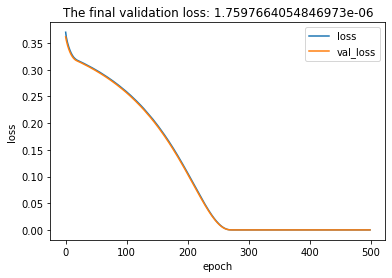

In [28]:
for label in ["loss","val_loss"]:
    plt.plot(hist2.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist2.history["val_loss"][-1]))
plt.legend()
plt.show()

Модель с линеной функцией активации более точна (по функции потерь на валидационном множестве), чем с tanh в качестве функции активации.

Важно! То, что было показано на паре (мгновенно <<обучившаяся>> модель с линейной активацией) --- ошибочно, так как тогда не была удалена старая модель.